In [253]:
# Import
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

# Import the finta Python library and the TA module
from finta import TA

In [254]:
# Import a new classifier from SKLearn
from sklearn.tree import DecisionTreeClassifier
from pandas.tseries.offsets import DateOffset
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import hvplot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import yfinance as yf

In [255]:
historical_data = yf.download('XLE', start='2000-01-01', end='2023-04-06')
historical_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,27.3125,27.31250,26.3750,26.562500,14.677702,380300
2000-01-04,26.3125,26.31250,25.8750,26.062500,14.401419,722200
2000-01-05,26.1250,26.75000,26.0000,26.750000,14.781302,337800
2000-01-06,26.7500,27.84375,26.7500,27.781250,15.351146,133100
2000-01-07,27.6875,28.40625,27.6875,28.078125,15.515189,468000


In [256]:
def make_features(org_df, short_window=4, long_window=10):
    
    # Filter the date index and close columns
    # signals_df = org_df.loc[:, ["close"]]
    signals_df = org_df.copy()

    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["Close"].pct_change()
    
    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()
    
    # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
    signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
    signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

    # Create additional technical indicators
    signals_df["SSMA"] = TA.SSMA(signals_df)            # Smoothed Simple Moving Average
    signals_df["EMA"] = TA.EMA(signals_df, 50)          # Exponential Moving Average
    signals_df["DEMA"] = TA.DEMA(signals_df)            # Double Exponential Moving Average
    signals_df["TEMA"] = TA.TEMA(signals_df)            # Triple Exponential Moving Average
    signals_df["TRIMA"] = TA.TRIMA(signals_df)          # Triangular Moving Average
    # signals_df["VWAP"] = TA.TRIMA(signals_df)           # Volume Weighted Average Price
    # signals_df["OBV"] = TA.OBV(signals_df)              # On Balance Volume
    # signals_df["VW_MACD"] = TA.VW_MACD(signals_df)      # Volume-Weighted MACD
    # signals_df["EV_MACD"] = TA.EV_MACD(signals_df)      # Elastic-Volume weighted MACD

    # Drop the NaNs using dropna()
    signals_df = signals_df.dropna()
    
    # Assign a copy of the technical variable columns to a new DataFrame called `X` and lag it.
    # X = signals_df[['SMA_Fast', 'SMA_Slow', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'VWAP', 'OBV']].shift().dropna().copy()
    X = signals_df[['SMA_Fast', 'SMA_Slow', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA']].shift().dropna().copy()
    # X = signals_df[['SMA_Fast', 'SMA_Slow', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'VWAP']].shift().dropna().copy()
    #X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()#.copy()

    # Initialize the new Signal column
    signals_df['Signal'] = 0.0
    
    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1
    
    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1
    
    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift(1)
    
    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']

    # Set the begining and end of the training set
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=6)

    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    
    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]
    
    # Create a StandardScaler instance
    scaler = StandardScaler()
    
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)
    
    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, signals_df, X_test

In [257]:
# Calculate parameters for best returns
# Interate through SMA and technical indicator input features
# shortterm window set from 1 to 20 days
# longterm window set from 80 to 280 days with a gap of 10 days.
best_return = 0
best_sw = 0
best_lw = 0
for sw in range(1,20):
    for lw in range(80,280,10):
        X_train_scaled, X_test_scaled, y_train, y_test, signals_df, X_test = make_features(historical_data, short_window=sw, long_window=lw)

        # Initiate the model instance
        decision_tree = DecisionTreeClassifier(random_state=101, max_depth=3)
        
        # Use RandomOverSampler to resample the datase using random_state=1
        ros = RandomOverSampler(random_state=1)
        X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

        # Fit the model using the training data
        # model = decision_tree.fit(X_train_scaled,y_train)
        model = decision_tree.fit(X_resampled, y_resampled)

        # Use the testing dataset to generate the predictions for the new model
        pred = decision_tree.predict(X_test_scaled)

        # Use a classification report to evaluate the model using the predictions and testing data
        testing_report = classification_report(y_test, pred)
        #print(testing_report)

        # Create a predictions DataFrame
        predictions_df = pd.DataFrame(index=X_test.index)

        # Add the SVM model predictions to the DataFrame
        predictions_df['Predicted'] = pred

        # Add the actual returns to the DataFrame
        predictions_df['Actual Returns'] = signals_df["Actual Returns"]
        
        # Add the strategy returns to the DataFrame
        predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df['Predicted']

        instance_return = np.product(1 + predictions_df["Strategy Returns"])
        if instance_return > best_return:
            best_return = instance_return
            best_sw = sw
            best_lw = lw
            print(best_return)

# Save the plot for best parameters
print(best_return)
print(best_sw)
print(best_lw)

0.1180689762868907
2.2675922425050854
2.5667664890952278
2.5667664890952278
10
180


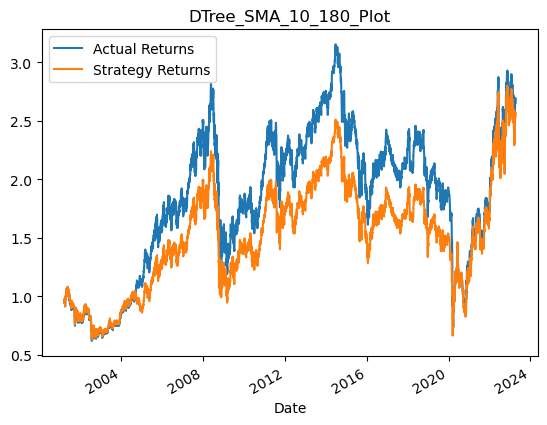

In [261]:
# Save the plot for the best set of parameters

X_train_scaled, X_test_scaled, y_train, y_test, signals_df, X_test = make_features(historical_data, short_window=best_sw, long_window=best_lw)
        
# Initiate the model instance
decision_tree = DecisionTreeClassifier(random_state=101, max_depth=3)
        
# Fit the model using the training data
model = decision_tree.fit(X_train_scaled,y_train)

result = model.predict(X_test_scaled)

# Use the testing dataset to generate the predictions for the new model
# pred = decision_tree.predict(X_test_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = pred
# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]
# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df['Predicted']

# Plot the actual returns versus the strategy returns
DTree_SMA_best_plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title='DTree_SMA_'+str(best_sw)+'_'+str(best_lw)+'_Plot').get_figure()
DTree_SMA_best_plot.savefig('DTree_SMA_best_Plot.png')

In [ ]:
def fit_model(input_df):
    # Calculate parameters for best returns
    # Interate through SMA and technical indicator input features
    # shortterm window set from 1 to 20 days
    # longterm window set from 80 to 280 days with a gap of 10 days.
    best_return = 0
    best_sw = 0
    best_lw = 0
    for sw in range(1,20):
        for lw in range(80,280,10):
            X_train_scaled, X_test_scaled, y_train, y_test, signals_df, X_test = make_features(input_df, short_window=sw, long_window=lw)

            # Initiate the model instance
            decision_tree = DecisionTreeClassifier(random_state=101, max_depth=3)
            
            # Use RandomOverSampler to resample the datase using random_state=1
            ros = RandomOverSampler(random_state=1)
            X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

            # Fit the model using the training data
            # model = decision_tree.fit(X_train_scaled,y_train)
            model = decision_tree.fit(X_resampled, y_resampled)

            # Use the testing dataset to generate the predictions for the new model
            pred = decision_tree.predict(X_test_scaled)

            # Use a classification report to evaluate the model using the predictions and testing data
            testing_report = classification_report(y_test, pred)
            # print(testing_report)

            # Create a predictions DataFrame
            predictions_df = pd.DataFrame(index=X_test.index)

            # Add the SVM model predictions to the DataFrame
            predictions_df['Predicted'] = pred

            # Add the actual returns to the DataFrame
            predictions_df['Actual Returns'] = signals_df["Actual Returns"]
            
            # Add the strategy returns to the DataFrame
            predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df['Predicted']

            instance_return = np.product(1 + predictions_df["Strategy Returns"])
            if instance_return > best_return:
                best_return = instance_return
                best_sw = sw
                best_lw = lw
                print(best_return)

    # Save the plot for best parameters
    print(best_return)
    print(best_sw)
    print(best_lw)

DecisionTreeClassifier(max_depth=3, random_state=101)
